Этот код использует библиотеки Optuna, MLflow и CatBoost для оптимизации гиперпараметров модели CatBoostRegressor на наборе данных Diabetes. Он загружает данные, определяет функцию для оптимизации, создает объект MLflowCallback, создает объект Optuna, запускает оптимизацию, получает лучшие параметры, обучает модель с лучшими параметрами, делает предсказание и выводит метрики.

In [2]:
import os
import optuna
import mlflow
import mlflow.sklearn
from mlflow.client import MlflowClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import optuna
from catboost import CatBoostRegressor
from optuna.integration.mlflow import MLflowCallback
import numpy as np
import random
from optuna.samplers import TPESampler
from numpy import median, array 

In [3]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "catb00st_optuna" # напишите название вашего эксперимента
RUN_NAME = "optuna"

FS_ASSETS = 'assets/optuna'
os.makedirs(FS_ASSETS, exist_ok=True)


pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

In [4]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [5]:
def get_artifact_runID(name):
    exp_ids=[]
    exps = client.search_experiments()
    got = False
    for e in exps:
        if not got:
            exp_ids.append(e.experiment_id)
            for e_id in exp_ids:
                runs = client.search_runs(e_id)
                for run in runs:
                    if run.info.status !='FAILED' and not got:
                        artifacts = client.list_artifacts(run.info.run_id)
                        #print(artifacts)
                        try:
                            
                            if name in str(artifacts):
                                run_id = run.info.run_id
                                print(run_id)
                                got = True
                        except:
                            pass
    return run_id

In [6]:
client = MlflowClient()
# Получаем список артефактов
the_run_id = get_artifact_runID("f_test.csv")

local_path = client.download_artifacts(the_run_id, "f_test.csv", 'data')
test = pd.read_csv(local_path)
test.sample(5)

2672a8996f4249ea82958891c914e4e3


,cats_transformer__encoder__nearest_metro,numeric__kitchen_area living_area^2,numeric__distance_to_metro,numeric__living_area^3,numeric__living_area,numeric__distance_to_metro^2,cats_transformer__bins_to_cats__build_year,numeric__kitchen_area living_area,cats_transformer__bins_to_cats__floors_total,cats_transformer__encoder__rooms,y
20420,1.265097e+07,0.000000,6.760780,32768.000000,32.000000,45.708143,1.028430e+07,0.000000,1.208004e+07,9.123777e+06,7800000
1539,1.180734e+07,8969.967968,43.832282,22665.187458,28.300000,1921.268964,1.368338e+07,316.959997,1.208004e+07,9.123777e+06,5950000
21243,1.180734e+07,7299.071288,12.280232,23887.867729,28.799998,150.804093,1.134803e+07,253.439990,1.208004e+07,9.123777e+06,8390000
28390,1.318194e+07,11200.000000,10.723335,64000.000000,40.000000,114.989924,1.134803e+07,280.000000,1.159648e+07,1.246098e+07,10000000
11759,1.062308e+07,31835.572400,1.031488,265847.709366,64.300000,1.063967,1.444640e+07,495.109989,1.159648e+07,1.567734e+07,12800000


In [7]:
the_run_id = get_artifact_runID("f_train.csv")

local_path = client.download_artifacts(the_run_id, "f_train.csv", 'data')
train = pd.read_csv(local_path)
train.sample(5)

2672a8996f4249ea82958891c914e4e3


,cats_transformer__encoder__nearest_metro,numeric__kitchen_area living_area^2,numeric__distance_to_metro,numeric__living_area^3,numeric__living_area,numeric__distance_to_metro^2,cats_transformer__bins_to_cats__build_year,numeric__kitchen_area living_area,cats_transformer__bins_to_cats__floors_total,cats_transformer__encoder__rooms,y
26169,1.183557e+07,10234.139622,2.065871,70444.993096,41.299999,4.267824,1.028985e+07,247.799995,1.158766e+07,1.243404e+07,10990000
46139,1.317351e+07,54670.328024,13.937311,275894.455850,65.100000,194.248629,1.384450e+07,839.789980,1.208511e+07,1.568549e+07,16850000
66443,1.264447e+07,18928.000000,7.266874,140608.000000,52.000000,52.807465,1.028985e+07,364.000000,1.158766e+07,1.566652e+07,16300000
54532,1.244538e+07,4056.000000,2.415950,17576.000000,26.000000,5.836816,1.448944e+07,156.000000,1.162271e+07,9.114923e+06,10500000
52787,1.240556e+07,67712.000000,4.913930,778688.000000,92.000000,24.146711,1.440886e+07,736.000000,1.158222e+07,1.902506e+07,15999000


In [8]:
X_train = train.drop(['y'], axis=1)
y_train = train['y']
X_test = test.drop(['y'], axis=1)
y_test = test['y']

Данные из ML-flow получены, теперь пора переходить к оптимизации гипер-параметров

In [ ]:
def objective(trial, X_train, X_test, y_train, y_test, experiment_id):
   """
   Функция-цель для оптимизации Optuna.

   Параметры:
   ----------
   trial : optuna.Trial
       Объект опыта Optuna.
   X_train : pandas.DataFrame
       Обучающий набор данных.
   X_test : pandas.DataFrame
       Тестовый набор данных.
   y_train : pandas.Series
       Целевая переменная для обучающего набора данных.
   y_test : pandas.Series
       Целевая переменная для тестового набора данных.
   experiment_id : str
       Идентификатор эксперимента MLflow.

   Возвращает:
   ----------
   float
       Значение метрики RMSE для тестового набора данных.
   """
   # Используем вложенные запуски для отслеживания каждого опыта в MLflow
   with mlflow.start_run(experiment_id = experiment_id, nested=True):
       # Определяем гиперпараметры для оптимизации
       params = {
           'iterations': trial.suggest_int('iterations', 100, 600),
           'depth': trial.suggest_int('depth', 2, 16),
           'min_child_samples': trial.suggest_int('min_child_samples', 2, 10),
           'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
           "subsample": trial.suggest_float("subsample", 0.05, 1.0),
           'loss_function': 'RMSE',
           'random_state': 42,
           'silent': True
       }
       
       # Логируем параметры
       for param_name, param_value in params.items():
           mlflow.log_param(param_name, param_value)
       
       # Создаем и обучаем модель
       model = CatBoostRegressor(**params)
       model.fit(X_train, y_train)
       
       # Делаем прогнозы и оцениваем
       y_pred = model.predict(X_test)
       metrics ={
           'neg_mean_absolute_error': - mean_absolute_error(y_pred, y_test),
           'neg_root_mean_squared_error': - mean_squared_error(y_pred, y_test),
           'r2': r2_score(y_pred, y_test),
           'neg_mean_absolute_percentage_error': - mean_absolute_percentage_error(y_pred, y_test)
       }
       
       # Логируем метрики
       mlflow.log_metrics(metrics)
       
       # Логируем модель
       mlflow.catboost.log_model(model, 'model')
       
       # Логируем важность признаков
       importance = pd.DataFrame({
           'feature': X_train.columns,
           'importance': model.feature_importances_
       }).sort_values('importance', ascending=False)
       
       fig, ax = plt.figure(figsize=(10, 6)), plt.axes()
       importance.plot.bar(x='feature', y='importance', ax=ax)
       plt.title('Feature Importance')
       plt.tight_layout()
       plt.savefig('feature_importance.png')
       mlflow.log_artifact('feature_importance.png')
       plt.close()
       
       print(f"Trial {trial.number}: RMSE={mean_squared_error(y_pred, y_test):.4f}, MAE={mean_absolute_error(y_pred, y_test):.4f}, R2={r2_score(y_pred, y_test):.4f}, MAPE%={mean_absolute_percentage_error(y_pred, y_test):.4f}")
       
       return mean_squared_error(y_pred, y_test)


In [ ]:
def run_optimization(experiment_id):
   """
   Запускает полный процесс оптимизации.

   Параметры:
   ----------
   experiment_id : str
       Идентификатор эксперимента MLflow.

   Возвращает:
   ----------
   None
   """
   # Настройка MLflow с использованием S3
   
   # Создание и запуск исследования Optuna с отслеживанием MLflow
   with mlflow.start_run(run_name="optuna_optimization", experiment_id=experiment_id):
       mlflow.log_param("optimizer", "optuna")
       mlflow.log_param("n_trials", 10)
       
       # Создание исследования
       study = optuna.create_study(direction='minimize', 
                                   study_name='cb_hyperparameter_optimization',
                                   pruner=optuna.pruners.MedianPruner())
       
       # Оптимизация с использованием частичной функции для передачи набора данных
       study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test, experiment_id), 
                      n_trials=10)
       
       # Логирование информации о лучшем опыте
       mlflow.log_params({f"best_{k}": v for k, v in study.best_params.items()})
       #mlflow.log_metric("best_rmse", study.best_value)
       
       # Вывод результатов
       print("\n" + "="*50)
       print("Best trial:")
       print(f"  Value (RMSE): {study.best_value:.4f}")
       print("  Params:")
       for key, value in study.best_params.items():
           print(f"    {key}: {value}")
       
       # Обучение лучшей модели
       best_model = CatBoostRegressor(**study.best_params)
       best_model.fit(X_train, y_train)
       
       # Логирование лучшей модели
       mlflow.sklearn.log_model(best_model, "optuna")
       
       # Генерация и логирование визуализаций оптимизации
       try:
           fig = optuna.visualization.plot_optimization_history(study)
           fig.write_image("optimization_history.png")
           mlflow.log_artifact("optimization_history.png")
           
           fig = optuna.visualization.plot_param_importances(study)
           fig.write_image("param_importances.png")
           mlflow.log_artifact("param_importances.png")
           
           fig = optuna.visualization.plot_slice(study)
           fig.write_image("slice_plot.png")
           mlflow.log_artifact("slice_plot.png")
       except Exception as e:
           print(f"Visualization error: {e}")
       
       print("\nOptimization completed. All results are logged to MLflow.")
       print(f"Best model saved with parameters: {study.best_params}")

if __name__ == "__main__":
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    if not experiment:
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
    else:
        experiment_id = experiment.experiment_id
    print(experiment)
    run_optimization(experiment_id)

<Experiment: artifact_location='s3://s3-student-mle-20250130-833968fcc1/20', creation_time=1741694413161, experiment_id='20', last_update_time=1741694413161, lifecycle_stage='active', name='catb00st_optuna', tags={}>


[I 2025-03-11 15:22:46,878] A new study created in memory with name: cb_hyperparameter_optimization
[I 2025-03-11 15:23:38,343] Trial 0 finished with value: 6526684678568.239 and parameters: {'iterations': 346, 'depth': 12, 'min_child_samples': 3, 'colsample_bylevel': 0.7905266376484396, 'subsample': 0.746273694675182}. Best is trial 0 with value: 6526684678568.239.


Trial 0: RMSE=6526684678568.2393, MAE=1954283.6492, R2=0.6444, MAPE%=0.1608


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:23:46,109] Trial 1 finished with value: 7076873411680.466 and parameters: {'iterations': 480, 'depth

Trial 1: RMSE=7076873411680.4658, MAE=2034095.7206, R2=0.5939, MAPE%=0.1663


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:23:50,793] Trial 2 finished with value: 7134395094710.186 and parameters: {'iterations': 124, 'depth

Trial 2: RMSE=7134395094710.1855, MAE=2040774.8329, R2=0.6023, MAPE%=0.1675


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:23:55,513] Trial 3 finished with value: 7830307592928.832 and parameters: {'iterations': 201, 'depth

Trial 3: RMSE=7830307592928.8320, MAE=2127021.9661, R2=0.5308, MAPE%=0.1722


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:24:06,302] Trial 4 finished with value: 6878453341582.678 and parameters: {'iterations': 478, 'depth

Trial 4: RMSE=6878453341582.6777, MAE=2006366.4768, R2=0.6124, MAPE%=0.1647


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:24:13,131] Trial 5 finished with value: 6993106694502.024 and parameters: {'iterations': 220, 'depth

Trial 5: RMSE=6993106694502.0244, MAE=2021982.0587, R2=0.6031, MAPE%=0.1656


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:24:22,697] Trial 6 finished with value: 6939430889624.721 and parameters: {'iterations': 559, 'depth

Trial 6: RMSE=6939430889624.7207, MAE=2016815.5678, R2=0.6025, MAPE%=0.1646


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:24:31,124] Trial 7 finished with value: 6861102098344.399 and parameters: {'iterations': 203, 'depth

Trial 7: RMSE=6861102098344.3994, MAE=2002627.1866, R2=0.6196, MAPE%=0.1646


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:24:38,170] Trial 8 finished with value: 7678402510258.18 and parameters: {'iterations': 348, 'depth'

Trial 8: RMSE=7678402510258.1797, MAE=2110390.7161, R2=0.5420, MAPE%=0.1714


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[I 2025-03-11 15:24:53,227] Trial 9 finished with value: 6728111627200.067 and parameters: {'iterations': 313, 'depth

Trial 9: RMSE=6728111627200.0674, MAE=1985097.4808, R2=0.6261, MAPE%=0.1632

Best trial:
  Value (RMSE): 6526684678568.2393
  Params:
    iterations: 346
    depth: 12
    min_child_samples: 3
    colsample_bylevel: 0.7905266376484396
    subsample: 0.746273694675182
Learning rate set to 0.199301
0:	learn: 4404659.3727983	total: 93.2ms	remaining: 32.2s
1:	learn: 3972413.8680361	total: 202ms	remaining: 34.8s
2:	learn: 3645794.6076509	total: 341ms	remaining: 38.9s
3:	learn: 3404915.4721984	total: 458ms	remaining: 39.1s
4:	learn: 3229816.7057119	total: 601ms	remaining: 41s
5:	learn: 3106516.5071651	total: 731ms	remaining: 41.4s
6:	learn: 3014254.8084321	total: 850ms	remaining: 41.2s
7:	learn: 2943997.8770092	total: 971ms	remaining: 41s
8:	learn: 2897780.5181240	total: 1.11s	remaining: 41.4s
9:	learn: 2862014.5480757	total: 1.24s	remaining: 41.7s
10:	learn: 2835823.7055332	total: 1.36s	remaining: 41.6s
11:	learn: 2813017.5187835	total: 1.47s	remaining: 40.8s
12:	learn: 2794774.5771424	tota

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(



Optimization completed. All results are logged to MLflow.
Best model saved with parameters: {'iterations': 346, 'depth': 12, 'min_child_samples': 3, 'colsample_bylevel': 0.7905266376484396, 'subsample': 0.746273694675182}


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Создание экземпляра модели CatBoostRegressor
clf = CatBoostRegressor(random_state=42, silent=True, loss_function='RMSE')

# Определение сетки параметров для поиска
param_grid = {
   "iterations": [100, 500],
   "depth": [2, 16],
   'min_child_samples': [2, 10],
   'colsample_bylevel': [0.05, 1.0],
   'subsample': [0.05, 1.0]
}

# Создание экземпляра HalvingGridSearchCV с использованием модели и сетки параметров
search = HalvingGridSearchCV(clf, param_grid, factor=2, max_resources=30)

# Обучение модели с использованием HalvingGridSearchCV
search.fit(X_train, y_train)

# Вывод лучших параметров, найденных в процессе поиска
search.best_params_

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/catboost/core.py:5934: RuntimeWarning:

divide by zero encountered in scalar divide

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/catboost/core.py", line 5807, in fit
    return s

{'colsample_bylevel': 0.05,
 'depth': 16,
 'iterations': 100,
 'min_child_samples': 2,
 'subsample': 1.0}

In [ ]:
EXPERIMENT_NAME = "HalvingGridSearchCV"  # Напишите название вашего эксперимента
RUN_NAME = "HalvingGrid"

# Получение эксперимента по имени
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# Если эксперимент не существует, создаем новый
if not experiment:
   experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
   experiment_id = experiment.experiment_id

# Запуск нового запуска MLflow
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id):
   # Логирование лучших параметров, найденных в процессе поиска
   mlflow.log_params(search.best_params_)
   
   # Создание экземпляра модели CatBoostRegressor с использованием лучших параметров
   clf = CatBoostRegressor(**search.best_params_, random_state=42, silent=True, loss_function='RMSE')
   
   # Обучение модели
   clf.fit(X_train, y_train)
   
   # Предсказание на тестовом наборе данных
   y_pred = clf.predict(X_test)
   
   # Вычисление метрик
   metrics = {
       'neg_mean_absolute_error': -mean_absolute_error(y_pred, y_test),
       'neg_root_mean_squared_error': -mean_squared_error(y_pred, y_test),
       'r2': r2_score(y_pred, y_test),
       'neg_mean_absolute_percentage_error': -mean_absolute_percentage_error(y_pred, y_test)
   }
   
   # Логирование метрик
   mlflow.log_metrics(metrics)
   
   # Логирование модели
   mlflow.catboost.log_model(clf, "HalvingGridSearchCV")
   
   # Вывод результатов
   print(f"RMSE={mean_squared_error(y_pred, y_test):.4f}, MAE={mean_absolute_error(y_pred, y_test):.4f}, R2={r2_score(y_pred, y_test):.4f}, MAPE%={mean_absolute_percentage_error(y_pred, y_test):.4f}")


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning:

Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml



RMSE=8545410020473.8291, MAE=2214775.2720, R2=0.4599, MAPE%=0.1793


In [30]:
exps

[<Experiment: artifact_location='s3://s3-student-mle-20250130-833968fcc1/21', creation_time=1741707336027, experiment_id='21', last_update_time=1741707336027, lifecycle_stage='active', name='HalvingGridSearchCV', tags={}>,
 <Experiment: artifact_location='s3://s3-student-mle-20250130-833968fcc1/20', creation_time=1741694413161, experiment_id='20', last_update_time=1741694413161, lifecycle_stage='active', name='catb00st_optuna', tags={}>,
 <Experiment: artifact_location='s3://s3-student-mle-20250130-833968fcc1/19', creation_time=1741685464806, experiment_id='19', last_update_time=1741685464806, lifecycle_stage='active', name='fit_exp', tags={}>,
 <Experiment: artifact_location='s3://s3-student-mle-20250130-833968fcc1/18', creation_time=1741343090127, experiment_id='18', last_update_time=1741343090127, lifecycle_stage='active', name='eda_exp', tags={}>,
 <Experiment: artifact_location='s3://s3-student-mle-20250130-833968fcc1/17', creation_time=1741182455592, experiment_id='17', last_upda

In [32]:
# Получение всех запусков из эксперимента
exps = client.search_experiments()
e_names ={}
runs = pd.DataFrame()
for x in exps:
   e_names[x.experiment_id]=x.name
   runs = pd.concat([runs,mlflow.search_runs(experiment_ids=x.experiment_id)], axis=0)

runs= runs[runs['status']=='FINISHED']
runs['experiment_name']=runs['experiment_id'].map(e_names)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.r2,metrics.neg_mean_absolute_error,metrics.neg_mean_absolute_percentage_error,metrics.neg_root_mean_squared_error,params.iterations,params.subsample,params.colsample_bylevel,params.min_child_samples,params.depth,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.runName,metrics.best_rmse,params.random_state,params.loss_function,params.silent,params.best_subsample,params.best_depth,params.best_min_child_samples,params.n_trials,params.best_colsample_bylevel,params.best_iterations,params.optimizer,tags.mlflow.parentRunId,params.learning_rate,metrics.score_time,metrics.test_neg_root_mean_squared_error,metrics.fit_time,metrics.test_neg_mean_absolute_error,metrics.test_neg_mean_absolute_percentage_error,metrics.test_r2,params.allow_writing_files,params.cat_features,experiment_name
0,9732b3ffa7fd4198b99c025e6c8a570b,21,FINISHED,s3://s3-student-mle-20250130-833968fcc1/21/973...,2025-03-11 15:35:36.045000+00:00,2025-03-11 15:35:38.728000+00:00,0.459936,-2.214775e+06,-0.179303,-8.545410e+12,100,1.0,0.05,2,16,mle-user,LOCAL,/home/mle-user/mle_projects/.venv/lib/python3....,"[{""run_id"": ""9732b3ffa7fd4198b99c025e6c8a570b""...",HalvingGrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HalvingGridSearchCV
0,6cad42be69b54248bda23f0974f4f4b8,20,FINISHED,s3://s3-student-mle-20250130-833968fcc1/20/6ca...,2025-03-11 15:24:38.172000+00:00,2025-03-11 15:24:53.201000+00:00,0.626110,-1.985097e+06,-0.163241,-6.728112e+12,313,0.8030672847531847,0.4468366710418784,9,9,mle-user,LOCAL,/home/mle-user/mle_projects/.venv/lib/python3....,"[{""run_id"": ""6cad42be69b54248bda23f0974f4f4b8""...",casual-tern-62,NaN,42,RMSE,True,None,None,None,None,None,None,None,b9a418608df841df80d8d1b28a4f5452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catb00st_optuna
1,e9fe01ef16f94de8806f60c7b3b48bea,20,FINISHED,s3://s3-student-mle-20250130-833968fcc1/20/e9f...,2025-03-11 15:24:31.126000+00:00,2025-03-11 15:24:38.147000+00:00,0.542037,-2.110391e+06,-0.171398,-7.678403e+12,348,0.7246823180262065,0.507038037992098,5,2,mle-user,LOCAL,/home/mle-user/mle_projects/.venv/lib/python3....,"[{""run_id"": ""e9fe01ef16f94de8806f60c7b3b48bea""...",dazzling-snake-765,NaN,42,RMSE,True,None,None,None,None,None,None,None,b9a418608df841df80d8d1b28a4f5452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catb00st_optuna
2,5e372d24b3294981afe1201aa885dc21,20,FINISHED,s3://s3-student-mle-20250130-833968fcc1/20/5e3...,2025-03-11 15:24:22.700000+00:00,2025-03-11 15:24:31.103000+00:00,0.619558,-2.002627e+06,-0.164602,-6.861102e+12,203,0.8726783053517331,0.795613806016817,7,8,mle-user,LOCAL,/home/mle-user/mle_projects/.venv/lib/python3....,"[{""run_id"": ""5e372d24b3294981afe1201aa885dc21""...",debonair-carp-836,NaN,42,RMSE,True,None,None,None,None,None,None,None,b9a418608df841df80d8d1b28a4f5452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catb00st_optuna
3,66281fcc8de04bd983d87bc31f0c22ac,20,FINISHED,s3://s3-student-mle-20250130-833968fcc1/20/662...,2025-03-11 15:24:13.133000+00:00,2025-03-11 15:24:22.675000+00:00,0.602507,-2.016816e+06,-0.164617,-6.939431e+12,559,0.1753620953633936,0.2649954909153941,7,8,mle-user,LOCAL,/home/mle-user/mle_projects/.venv/lib/python3....,"[{""run_id"": ""66281fcc8de04bd983d87bc31f0c22ac""...",skillful-hen-866,NaN,42,RMSE,True,None,None,None,None,None,None,None,b9a418608df841df80d8d1b28a4f5452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,catb00st_optuna
4,828d013dd1f24b9d8ab184b36adf3d88,20,FINISHED,s3://s3-student-mle-20250130-833968fcc1/20/828...,2025-03-11 15:24:06.305000+00:00,2025-03-11 15:24:13.105000+00:00,0.603053,-2.021982e+06,-0.165596,-6.993107e+12,220,0.8862049893027723,0.2205408993834999,9,8,mle-user,LOCAL,/home/mle-user/mle_projects/.venv/lib/python3....,"[{""run_id"": ""828d013dd1f24b9d8ab184b36adf3d88""...",youthful-hawk-931,NaN,42,RMSE,True,None,None,None,None,None,None,None,b9a418608df841df80d8d1b28a4f5452,NaN,NaN,NaN,NaN,NaN,

In [71]:
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
def scatter_metric(metr, ax):
    custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='grey', lw=2)]
    r2s =runs.dropna(subset=['metrics.r2']).sort_values(by='end_time', ascending=True)
    color =dict(zip(['HalvingGridSearchCV', 'catb00st_optuna', 'fit_exp'],['green','orange','grey']))
    colors = [color[x] for x in r2s['experiment_name']]
    ax = sns.scatterplot(x=r2s['run_id'],y=metr,data=r2s, c=colors, ax=ax)
    ax.legend(custom_lines, ['HalvingGridSearchCV', 'catb00st_optuna', 'fit_exp'],loc='best')
    ax.xaxis.set_major_locator(ticker.NullLocator())
    return ax


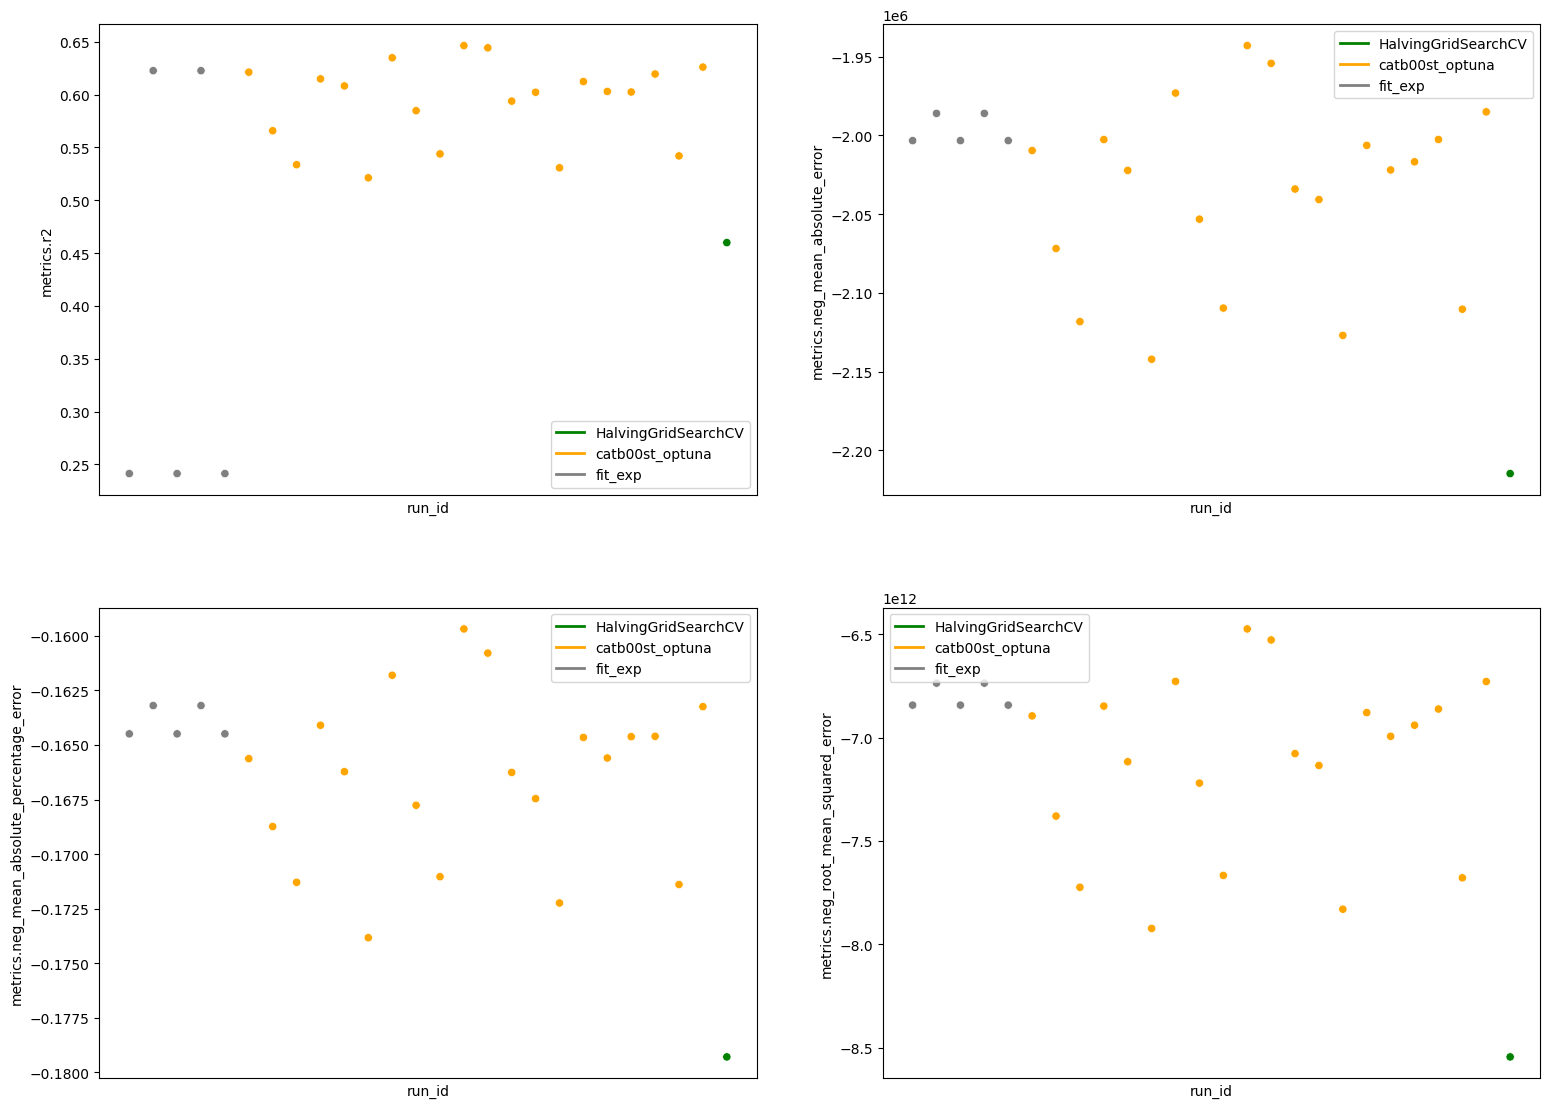

In [72]:
metrs = ['metrics.r2',	'metrics.neg_mean_absolute_error',	'metrics.neg_mean_absolute_percentage_error',	'metrics.neg_root_mean_squared_error']
fig, axs = plt.subplots(2, 2, figsize=(16.5, 12.5))
fig.tight_layout(pad=6)
for i, metr in enumerate(metrs):
    axs[i//2, i%2] = scatter_metric(metr, axs[i//2, i%2])
#plt.savefig(f'{ASSETS_DIR}/cat_features_1.png')
plt.show()

*Вывод*: Сранение метрик позволяет сделать вывод, что наилучшие результаты были достигнута на одном из триалов при работе модуля optuna.
При этом драматического улучшенния по сравнению с базовой моделью достигнуто не было. Но никто особо и не рассчитывал, что оптимизация гипер-параметров даст больший эффект, чем предобработка данных.

**Глобальный вывод по исследованию**  
Гипотеза пока себя не оправдывает. Не получется создать модель, дающую приемлемую точность оценки квартиры. Когда система ошибается при оценке квартиры в пару миллионов, что покупатель, что продавец, скорее будут испытывать только раздражение.
